# Imports

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For text preprocessing
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import spacy

# Metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

import torch 
import torch.nn.functional as F
import spacy
import torch.nn as nn
from collections import Counter

# Reading the data and creating dataset

In [2]:
data = pd.read_csv("Constraint_English_Train - Sheet1.csv")
val = pd.read_csv("Constraint_English_Val - Sheet1.csv")
test = pd.read_csv("english_test_with_labels - Sheet1.csv")

In [3]:
print(f"Number of training samples: {len(data)}")
print(f"Number of validation samples: {len(val)}")
print(f"Number of testing samples: {len(test)}")

Number of training samples: 6420
Number of validation samples: 2140
Number of testing samples: 2140


<AxesSubplot:>

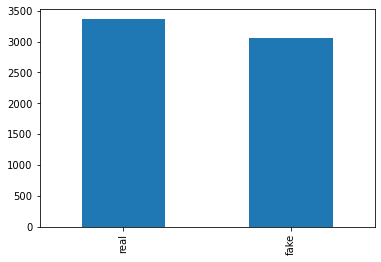

In [4]:
# Distribution of the training dataset
data['label'].value_counts().plot(kind='bar')

In [5]:
conda install -c conda-forge spacy

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [6]:
# Frequent words in the English language which would not aid classification
stop_words = set(stopwords.words("english"))
tok = spacy.load('en_core_web_sm')
def process_text(string):
    """
    Replaces "http", "www" in urls with space.
    Replaces ampersand(&) with "and"
    Removes non-alphanumeric characters
    Removes stop words
    """
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stop_words]
    text = " ".join(text)
    text = [token.text for token in tok.tokenizer(text)]
    return text

In [7]:
data['tweet'] = data['tweet'].apply(lambda x: process_text(x))
val['tweet'] = val['tweet'].apply(lambda x: process_text(x))
test['tweet'] = test['tweet'].apply(lambda x: process_text(x))

In [8]:
counts = Counter()
for index, row in data.iterrows():
    counts.update(row['tweet'])

vocab2idx = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2idx[word] = len(words)
    words.append(word)

idx2vocab = {ii : w for w, ii in vocab2idx.items()}

In [9]:
def encode_sentence(text, vocab2index, N=32):
    encoded = np.zeros(N, dtype=int)
    enc = np.array([vocab2idx.get(word, vocab2idx["UNK"]) for word in text])
    length = min(N, len(enc))
    encoded[:length] = enc[:length]
    return encoded, length

In [10]:
data['encoded'] = data['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))
val['encoded'] = val['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))
test['encoded'] = test['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))

/var/folders/0k/h8p0bgts4g5113f9brnt4l4w0000gn/T/ipykernel_70091/4113796800.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data['encoded'] = data['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))
/var/folders/0k/h8p0bgts4g5113f9brnt4l4w0000gn/T/ipykernel_70091/4113796800.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val['encoded'] = val['tweet'].apply(lambda x: np.array(encode_sentence(x,vocab2idx)))
/var/folders/0k/h8p0bgts4g5113f9brnt4l4w0000gn/T/ipykernel_70091/4113796800.py:3: VisibleDeprecationWarning: Creating an ndarray

In [11]:
data['label_encoded'] = data['label'].apply(lambda x : 0 if x == "fake" else 1)
val['label_encoded'] = val['label'].apply(lambda x : 0 if x == "fake" else 1)
test['label_encoded'] = test['label'].apply(lambda x : 0 if x == "fake" else 1)

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TweetDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0]), self.y[idx], self.X[idx][1]
    
    def __len__(self):
        return len(self.y)
    
train_data = TweetDataset(data['encoded'], data['label_encoded'])
val_data = TweetDataset(val['encoded'], val['label_encoded'])
test_data = TweetDataset(test['encoded'], test['label_encoded'])

batch_size = 128
vocab_size = len(words)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size)
testloader = DataLoader(test_data, batch_size=batch_size)

# Train Function

In [129]:
def train_model(model, epochs=4, lr=0.001):
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    criterion = nn.BCELoss()
    
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in trainloader:
            # print(x)
            x = x.long()
            y = y.float()
            yhat = model(x).squeeze()
            # print(y)
            # print(yhat)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        
        model.eval()
        correct = 0
        total = 0
        sum_loss_val = 0.0

        for x, y, l in valloader:
            x = x.long()
            y = y.float()
            y_hat = model(x).squeeze()
            loss = criterion(y_hat, y)
            # print(y_hat)
            pred = y_hat >= 0.5
            # print(pred)
            correct += (pred == y).float().sum()
            total += y.shape[0]
            sum_loss_val += loss.item()*y.shape[0]

        val_acc = correct/total
        val_loss = sum_loss_val/total
        if i % 2 == 1:
            print("epoch %d train loss %.3f, val loss %.3f, val accuracy %.3f" % (i+1, sum_loss/total, val_loss, val_acc))


In [104]:
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []

        with open(os.path.join(embedding_name), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [
            self.token_to_idx.get(token, self.unknown_idx)
            for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

# CNN 

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,**kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)


        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 1)


        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()

        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):

        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat(
            (self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
            
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels

        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels

        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)

        outputs = F.sigmoid(self.decoder(self.dropout(encoding)))
        
        
        return outputs

In [103]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
net = TextCNN(len(vocab2idx), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

In [105]:
glove_embedding = TokenEmbedding('glove.6b.100d.txt')
embeds = glove_embedding[idx2vocab]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [107]:
train_model(net)

epoch 2 train loss 0.492, val loss 0.169, val accuracy 0.936
epoch 4 train loss 0.097, val loss 0.174, val accuracy 0.938


In [108]:
net.eval()
correct = 0
total = 0
sum_loss_test = 0.0
criterion = nn.BCELoss()

for x, y, l in testloader:
    x = x.long()
    y = y.float()
    y_hat = net(x).squeeze()
    loss = criterion(y_hat, y)
    pred = y_hat >= 0.5
    correct += (pred == y).float().sum()
    total += y.shape[0]
    sum_loss_test += loss.item()*y.shape[0]

In [109]:
correct/total

tensor(0.9304)

In [110]:
torch.save(net.state_dict(), "cnn_model.pt")

# Bidirectional RNN

In [125]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 1)

    def forward(self, inputs):

        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()

        outputs, _ = self.encoder(embeddings)

        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)

        outs = torch.sigmoid(self.decoder(encoding))
        return outs

In [130]:
embed_size, num_hiddens, num_layers = 100, 64, 2
net_rnn = BiRNN(len(vocab2idx), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net_rnn.apply(init_weights);

In [131]:
glove_embedding = TokenEmbedding('glove.6b.100d.txt')
embeds = glove_embedding[idx2vocab]
net_rnn.embedding.weight.data.copy_(embeds)
# net_rnn.embedding.weight.requires_grad = False

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [132]:
train_model(net_rnn,lr=0.01, epochs=10)

epoch 2 train loss 0.178, val loss 0.208, val accuracy 0.921
epoch 4 train loss 0.017, val loss 0.395, val accuracy 0.919
epoch 6 train loss 0.015, val loss 0.496, val accuracy 0.907
epoch 8 train loss 0.057, val loss 0.337, val accuracy 0.931
epoch 10 train loss 0.011, val loss 0.451, val accuracy 0.916


In [133]:
net_rnn.eval()
correct = 0
total = 0
sum_loss_test = 0.0
criterion = nn.BCELoss()

for x, y, l in testloader:
    x = x.long()
    y = y.float()
    y_hat = net_rnn(x).squeeze()
    loss = criterion(y_hat, y)
    pred = y_hat >= 0.5
    correct += (pred == y).float().sum()
    total += y.shape[0]
    sum_loss_test += loss.item()*y.shape[0]

print(correct/total)

tensor(0.9136)


# Attention

In [13]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [14]:
data.head()

,id,tweet,label,encoded,label_encoded
0,1,"[cdc, currently, reports, 99031, deaths, gener...",real,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ...",1
1,2,"[states, reported, 1121, deaths, small, rise, ...",real,"[[21, 22, 23, 6, 13, 24, 25, 26, 27, 21, 22, 2...",1
2,3,"[politically, correct, woman, almost, uses, pa...",fake,"[[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...",0
3,4,"[indiafightscorona, 1524, covid, testing, labo...",real,"[[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, ...",1
4,5,"[populous, states, generate, large, case, coun...",real,"[[58, 21, 59, 60, 61, 10, 62, 63, 64, 65, 66, ...",1


In [45]:
import os
embeddings_index = {}
f = open(os.path.join('glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [15]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [88]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])

tokenized_data = tokenizer.texts_to_sequences(data['tweet'])
X_train = pad_sequences(tokenized_data, maxlen=32, padding='post')
y_train = data['label_encoded']

tokenized_val = tokenizer.texts_to_sequences(val['tweet'])
X_val= pad_sequences(tokenized_val, maxlen=32, padding='post')
y_val= val['label_encoded']

In [89]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [108]:
seq_input = Input(shape=(32,), dtype="int32")
embedded_sequences = Embedding(len(word_index)+1, 100, weights=[embedding_matrix])(seq_input)

In [109]:
lstm = Bidirectional(LSTM(32, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(32, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)


In [110]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
x = Dense(128, activation="relu")(context_vector)
x = Dense(128, activation="relu")(x)
x= Dense(128, activation="relu")(x)
# dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(x)
  
model = keras.Model(inputs=seq_input, outputs=output)

In [69]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [111]:
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [112]:
BATCH_SIZE = 32
EPOCHS = 20
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/20


2021-11-05 12:56:14.945526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 12:56:15.210696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 12:56:15.222959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 12:56:15.349113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 12:56:15.358355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 12:56:15.772820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 12:56:15.773323: I tensorflow/core/grappler/optimizers/cust

201/201 [==============================] - 17s 73ms/step - loss: 0.4948 - accuracy: 0.7615 - precision: 0.7455 - recall: 0.8265
Epoch 2/20
201/201 [==============================] - 14s 67ms/step - loss: 0.3987 - accuracy: 0.8254 - precision: 0.8235 - recall: 0.8482
Epoch 3/20
201/201 [==============================] - 13s 66ms/step - loss: 0.3603 - accuracy: 0.8436 - precision: 0.8455 - recall: 0.8580
Epoch 4/20
201/201 [==============================] - 13s 66ms/step - loss: 0.3259 - accuracy: 0.8575 - precision: 0.8646 - recall: 0.8628
Epoch 5/20
201/201 [==============================] - 13s 65ms/step - loss: 0.3198 - accuracy: 0.8625 - precision: 0.8670 - recall: 0.8708
Epoch 6/20
201/201 [==============================] - 13s 65ms/step - loss: 0.3122 - accuracy: 0.8653 - precision: 0.8734 - recall: 0.8685
Epoch 7/20
201/201 [==============================] - 13s 65ms/step - loss: 0.3057 - accuracy: 0.8673 - precision: 0.8688 - recall: 0.8792
Epoch 8/20
201/201 [==================

In [113]:
model.evaluate(X_val, y_val)

2021-11-05 13:03:52.100000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 13:03:52.232804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 13:03:52.240083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 13:03:52.375474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 13:03:52.382082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 3s 33ms/step - loss: 0.2906 - accuracy: 0.8794 - precision: 0.8954 - recall: 0.8714


[0.29064199328422546,
 0.8794392347335815,
 0.8954128623008728,
 0.8714285492897034]